# Feature Correlations Plot

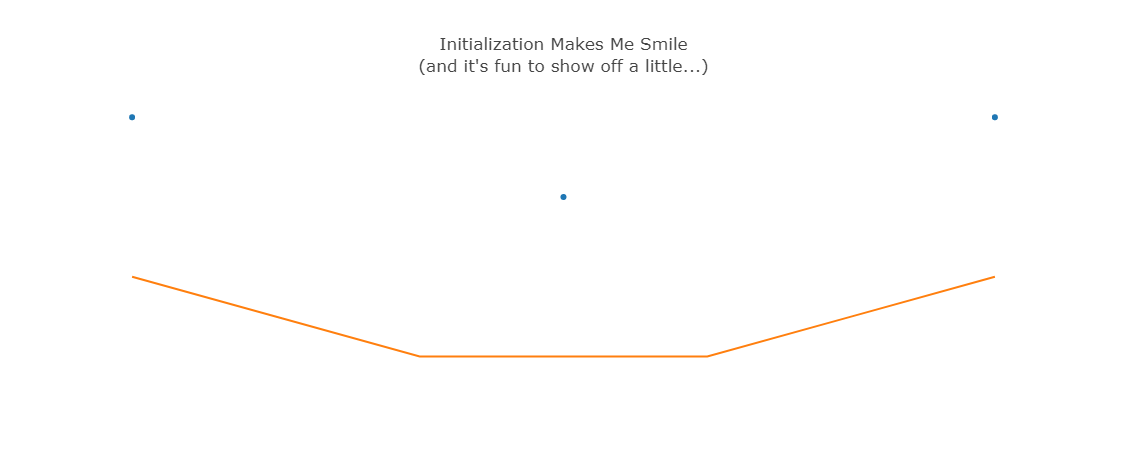

In [1]:
import math
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Latex, HTML, IFrame

import plotly.plotly as ply
import plotly.tools as plytool
import plotly.graph_objs as go
import plotly.offline as plyoff

# plotly initialization
# if using jupyter lab, must have the plotly extension installed: https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension
# jupyter labextension install @jupyterlab/plotly-extension
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({"x":x1, "y":y1, 'mode':'markers'}),
                             go.Scatter({"x":x2, "y":y2, 'mode':'lines'})],
                                        layout=go.Layout(autosize=False,width=500,title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)",
                                                         showlegend=False, xaxis={'showgrid':False, 'showticklabels':False},
                                                         yaxis={'showgrid':False, 'showticklabels':False})))

# plotly authentication - not needed for offline mode
plytool.set_credentials_file(username='ahowe42', api_key='PEbf792steMBTCn3TcSR')

## Create the function that generates the feature correlations plot

In [2]:
def CorrelationsPlot(rhoYourBoat, trcLims=(0.0,1.0)):
    '''
    This creates and returns a bubble plot visualization of a correlation matrix. The
    sizes of the bubbles are proportional to the absolute magnitude of the correlations.
    Positive correlations are only plotted in the upper triangle, with colors ranging
    from green (0) to red (+1). Negative correlations are plotted in the lower triangle,
    with colors ranging from green (0) to blue (-1). Perfect correlations are indicated
    with black bubbles.
    
    Input:
        rhoYourBoat = dataframe of correlation matrix, probably created with pd.DataFrame.corr()
        trcLims (default=(0.0,1.0)) = ordered tuple of "buckets" in which to place
            absolute correlations for plotting traces; must include at least 0 and 1
    Output:
        fig = plotly correlation plot figure
    '''
    
    # set the granulatrity of the colors
    n = 101 # must be odd so in the middle at correlation = 0 is just green
    
    # number features
    p = len(rhoYourBoat.columns)
    ps = list(range(p))    
    
    # positive correltions are red>green
    scl = np.linspace(1.0,0.0,n)
    redsP = np.round(255*scl)
    grnsP = 255-redsP
    blusP = [0.0]*n
    
    # negative correlations are blue>green
    scl = scl[:-1]
    blusN = np.round(255*scl)
    grnsN = 255-blusN
    redsN = [0.0]*n
    
    # adding 2 more to make the endpoints for perfect correlations
    scl = np.linspace(-1.0,1.0,2*n-1+2)     

    # make the colormap - perfectly uncorrelated and perfectly correlated are black
    rgb = ['rgb(0,0,0)']
    rgb.extend(['rgb(%d,%d,%d)'%(r,g,b) for r,g,b in zip(np.r_[redsN,redsP[::-1]],np.r_[grnsN,grnsP[::-1]],np.r_[blusN,blusP[::-1]])])
    rgb.append('rgb(0,0,0)')

    # now map correlations to colors - unhappy that I have to do this double loop :-(
    vals = rhoYourBoat.values
    cols = np.zeros(shape=vals.shape, dtype=object)
    for i in ps:
        for j in ps:
            v = vals[i,j]
            mni = np.argmin(np.abs(v-scl))
            mnv = scl[mni]
            cols[i,j] = rgb[mni]
            #print('%0.5f,%d,%0.5f,%s'%(v,mni,mnv,cols[i,j]))
    #import ipdb; ipdb.set_trace()
    # filter data so the upper triangle is (+) correlations and lower triangle is (-) correlations
    y = np.tile(ps,(p,1)); x = y.T
    x = x.flatten(); y = y.flatten()
    vals = vals.flatten()
    cols = cols.flatten()
    keepind = ((y>x) & (vals>0)) | ((x>y) & (vals<0))
    x = x[keepind]; y = y[keepind]
    vals = vals[keepind]
    cols = cols[keepind]
    absVals = np.abs(vals)

    # put together the figure - make multiple traces
    trc = [go.Scatter({'x':ps, 'y':ps, 'mode':'lines', 'line':{'color':'black'}, 'showlegend':False, 'hoverinfo':'skip'})]
    for i,t in enumerate(trcLims):
        # build the index for the traces
        if i==0:
            continue
        elif i==1:
            indx = (absVals <= t) & (absVals >= trcLims[0])
            trcName = '$\\vert\\rho\\vert\\in[%0.2f,%0.2f]$'%(trcLims[0],t)
        else:
            indx = (absVals <= t) & (absVals > trcLims[i-1])
            trcName = '$\\vert\\rho\\vert\\in(%0.2f,%0.2f]$'%(trcLims[i-1],t)
        # create & add the trace
        trc.append(go.Scatter({'x':x[indx], 'y':y[indx], 'mode':'markers', 'text':['%0.4f'%v for v in vals[indx]],
                       'name':trcName, 'hoverinfo':'x+y+text',
                      'marker':{'color':cols[indx],'size':15*absVals[indx],'line':{'color':cols[indx]}}}))
        
    # finalize the layout
    lout= go.Layout({'title':'Feature Correlations Plot',#'width':1200,'height':1200,
                     'legend':{'orientation':'h','x':0.0,'y':1+1/p},
                     'xaxis':{'ticklen':1,'tickvals':ps,'ticktext':rhoYourBoat.columns.values,
                              'mirror':True,'showgrid':False,'range':[-1,p],'linecolor':'black',
                              'linewidth':0.5,'zeroline':False},
                     'yaxis':{'ticklen':1,'tickvals':ps,'ticktext':rhoYourBoat.index.values,
                              'mirror':True,'showgrid':False,'range':[-1,p],'linecolor':'black',
                              'linewidth':0.5,'zeroline':False}})

    return go.Figure(data=trc, layout=lout)

# Demonstrate the Feature Correlations Plot using some simulated datasets

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6
Feature 0,1.0,0.0,0.1,0.2,0.3,0.4,0.5
Feature 1,0.0,1.0,0.6,0.7,0.8,0.9,1.0
Feature 2,0.1,0.6,1.0,-0.1,-0.2,-0.3,-0.4
Feature 3,0.2,0.7,-0.1,1.0,-0.5,-0.6,-0.7
Feature 4,0.3,0.8,-0.2,-0.5,1.0,-0.8,-0.9
Feature 5,0.4,0.9,-0.3,-0.6,-0.8,1.0,-1.0
Feature 6,0.5,1.0,-0.4,-0.7,-0.9,-1.0,1.0


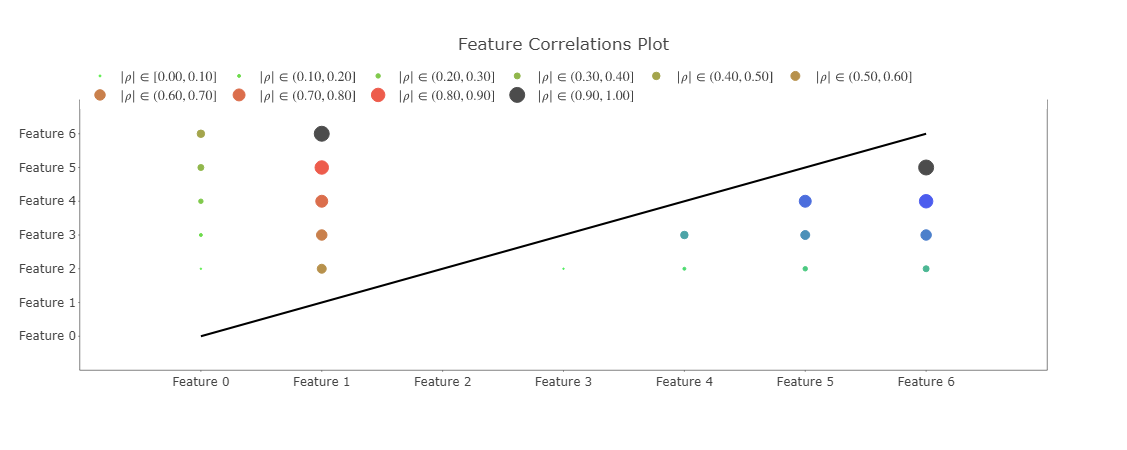

In [3]:
''' create a symmetric correlation matrix showing the range of possible correlations'''
# generate values
vals = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
vals.extend([-i for i in vals[1:]])

# create the correlation matrix
p = 7 # dimension of correlation matrix including the diagonal of 1s
corrs = np.zeros((p,p),dtype=float)  # create the square matrix
corrs[np.triu_indices(p,1)] = vals   # put correlations on upper triangle
corrs = corrs + corrs.T + np.eye(p)  # add the diagonal and fold over it

# make the dataframe
cols = ['Feature %d'%i for i in range(p)]
corrs = pd.DataFrame(data=corrs, columns=cols, index=cols)
display(corrs)

# visualize
plyoff.iplot(CorrelationsPlot(corrs, trcLims=np.linspace(0.0,1.0,11)))

D:\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning:

covariance is not symmetric positive-semidefinite.



,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14
Feature 0,1.000000,0.086346,-0.132330,-0.407491,0.001355,0.110181,-0.133270,0.363291,0.278162,-0.063531,-0.018015,0.195384,0.021674,0.216578,-0.128931
Feature 1,0.086346,1.000000,0.046881,-0.042778,0.020062,-0.295471,0.137732,-0.122562,0.028051,-0.085980,-0.198107,0.427383,-0.462479,0.268979,0.107803
Feature 2,-0.132330,0.046881,1.000000,-0.198902,-0.274197,-0.022697,0.150956,0.181112,0.008428,0.638913,0.139232,-0.223920,0.187989,0.024067,0.022935
Feature 3,-0.407491,-0.042778,-0.198902,1.000000,0.032433,-0.119924,-0.031241,-0.506782,-0.333663,-0.068280,-0.169954,-0.071092,0.098165,-0.299561,0.124524
Feature 4,0.001355,0.020062,-0.274197,0.032433,1.000000,0.001302,-0.176155,-0.158633,0.255908,-0.524155,-0.094279,0.045231,-0.152546,0.027274,-0.126591
Feature 5,0.110181,-0.295471,-0.022697,-0.119924,0.001302,1.000000,0.019973,-0.385193,-0.268015,0.111372,0.165290,0.226477,-0.144198,0.043895,-0.126542
Feature 6,-0.133270,0.137732,0.150956,-0.031241,-0.176155,0.019973,1.000000,-0.120709,-0.321479,0.294020,-0.034923,-0.183003,-0.017316,-0.436863,0.452834
Feature 7,0.363291,-0.122562,0.181112,-0.506782,-0.158633,-0.385193,-0.120709,1.000000,0.257239,0.022645,0.237214,-0.312682,0.250094,0.269736,-0.023941
Feature 8,0.278162,0.028051,0.008428,-0.333663,0.255908,-0.268015,-0.321479,0.257239,1.000000,-0.264269,-0.476306,0.271226,0.002255,0.534756,-0.216726
Feature 9,-0.063531,-0.085980,0.638913,-0.068280,-0.524155,0.111372,0.294020,0.022645,-0.264269,1.000000,0.311994,-0.372697,0.088878,-0.319917,0.121609


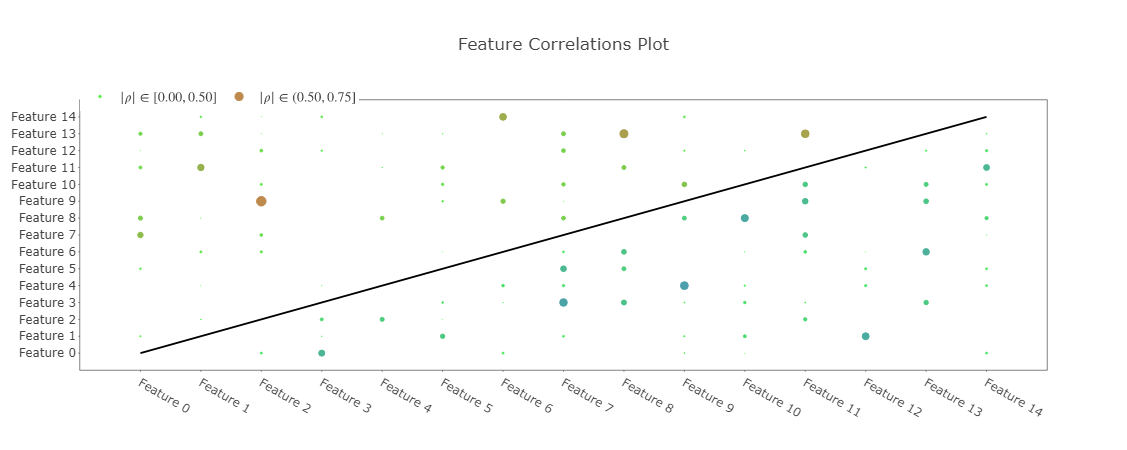

In [4]:
''' generate random (n,p) data with random correlations & standard deviations'''
np.random.seed(12111906)
n = 200; p = 15; q = int(p*(p+1)/2-p)
# first make a correlation matrix with random correlations
vals = np.random.randint(low=-100, high=101, size=q)/100
r = np.zeros((p,p),dtype=float)  # create the square matrix
r[np.triu_indices(p,1)] = vals   # put correlations on upper triangle
r = r + r.T + np.eye(p)
# now make a covariance matrix with random standard deviations
d = np.diag(np.random.randint(low=1, high=100, size=p)/10)
sigma = np.matmul(np.matmul(d,r),d)

# simulate data
data = pd.DataFrame(data=np.random.multivariate_normal(mean=[0]*p, cov=sigma, size=n), columns=['Feature %d'%i for i in range(p)])
corrs = data.corr()
display(corrs)

# visualize
plyoff.iplot(CorrelationsPlot(corrs, trcLims=(0,0.5,0.75,0.9,1.0)))

## Demonstrate the Feature Correlations Plot using a real-world dataset

In [5]:
# get the data
yourBoat = pd.read_csv('data.csv')
display(yourBoat.head())

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44
0,1.567691,0.688604,-0.223465,-0.860063,-0.873414,1.0,0.376509,1.368553,0.668687,1.666667,...,-0.818182,-0.2,-1.467001,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.641916,0.212910,-0.223465,-0.847689,-0.873065,0.0,0.131700,0.569071,0.216739,1.666667,...,-0.818182,-0.2,-0.727043,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.143979,-0.128524,-0.223465,-0.844084,-0.872825,0.0,-0.093892,-0.170489,-0.137827,1.666667,...,-0.818182,-0.2,-0.039823,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.523146,-0.289406,-0.223465,-0.818249,-0.870506,0.0,-0.210239,-0.547613,-0.314629,1.666667,...,-0.818182,-0.2,0.314605,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.697899,-0.350004,-0.223465,-0.854992,-0.870724,0.0,-0.257987,-0.723649,-0.382946,1.666667,...,-0.818182,-0.2,0.460060,-1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# create the correlation matrix & visualize it
rhoYourBoat = yourBoat.corr()
print('Correlation Matrix')
display(rhoYourBoat.head())

Correlation Matrix


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44
Feature 0,1.000000,0.515418,0.003181,0.003040,-0.044016,0.145920,0.278383,0.893897,0.622778,0.122802,...,0.112764,0.204094,-0.813311,0.092590,-0.014457,0.038953,0.047555,0.013553,0.106115,-0.055969
Feature 1,0.515418,1.000000,-0.048969,-0.000402,-0.004410,0.025075,-0.003805,0.185153,0.510606,-0.078699,...,0.118603,0.097683,-0.239027,0.114960,0.013539,-0.008364,0.019189,0.077993,-0.013865,-0.022113
Feature 2,0.003181,-0.048969,1.000000,0.252372,0.292024,0.133567,0.738512,0.004836,-0.142238,0.389801,...,-0.331494,-0.146407,0.001122,-0.311997,-0.150927,0.066383,0.004575,-0.215211,-0.001999,-0.290431
Feature 3,0.003040,-0.000402,0.252372,1.000000,0.973526,0.016487,0.217848,0.019984,0.027256,-0.080666,...,-0.005756,-0.005116,-0.039510,0.037549,0.125101,-0.115623,-0.010565,0.032897,-0.039160,0.083329
Feature 4,-0.044016,-0.004410,0.292024,0.973526,1.000000,0.015959,0.216658,-0.033365,0.009868,-0.096457,...,-0.006644,-0.011140,0.001283,0.041069,0.118215,-0.100402,-0.003986,0.034686,-0.041461,0.080311


In [7]:
# visualize the correlation matrix
pltCorr = CorrelationsPlot(rhoYourBoat, trcLims=(0,0.5,0.75,0.9,0.95,1.0))
plyoff.plot(pltCorr, filename='feature_correlations.html', auto_open=True, include_mathjax='cdn') # save one to file, in addition to the display

'file://G:\\JohnHunterAward\\feature_correlations.html'